In [581]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import arviz as az
from sklearn.linear_model import QuantileRegressor
import pymc as pm
import pytensor
import pytensor.tensor as pt
from scipy import stats
import patsy
from torch import nn
import torch
import torch.nn as nn
import torch.optim as optim


torch.Size([365, 1, 1])


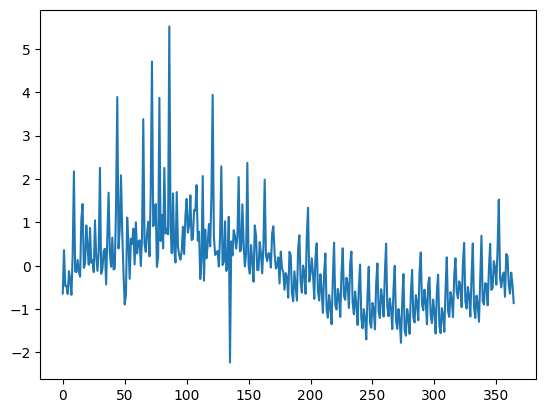

In [582]:
def generate_time_series(t=1000):
    'Generate heteroscedastic time series for an inference problem'

    t = np.arange(0,t)
    np.random.seed(1)
    # Generate a non-stationary time series corresponding to the local m
    weekly = 1.5*np.sin(2*np.pi*t/7)**3 + 5*np.sin(2*np.pi*t/7)**2 + np.sin(2*np.pi*t/7)*0.5
    weekly = weekly - np.mean(weekly)
    monthly = 0.5*np.sin(2*np.pi*t/30 + 10) + 0.8*np.sin(2*np.pi*t/30 + 10)**3
    monthly = monthly - np.mean(monthly)
    yearly  = 4*np.sin(2*np.pi*t/365)
    yearly = yearly - np.mean(yearly)

    
    # Generate a time series with gaussian random walk distribution
    mu = 2*(monthly + weekly + yearly)
    sd = np.exp(weekly*0.5 + monthly)
    y = np.random.normal(mu, scale=0.01)

   
    y = y + np.random.normal(0, scale=np.exp(y*0.2), size=len(t))
    return y


y= generate_time_series(365)
y = (y - np.mean(y))/np.std(y)

plt.plot(np.arange(0, len(y)), y)

y = np.array(y, dtype="float32")
X = np.roll(y, 1)
X[-1] = np.nan

# Change the tensor dimensions
y = torch.tensor(y)
# One step ahead prediction - feed in the previous data point (dont include the seasonal variables)

X = torch.tensor(X)
X = torch.unsqueeze(X, 1)
X = torch.unsqueeze(X, 1)
print(X.size())


# Example usage
batch_size = 4
sequence_length = 365*5
x1 = torch.randn(batch_size, sequence_length, 1)
x2 = torch.randn(batch_size, sequence_length, 1)
y = torch.randn(batch_size, sequence_length, 1)

X = torch.cat((x1, x2, y), dim=2)

In [612]:
import numpy as np

# Generate synthetic data
def generate_data(num_samples, seq_length, input_features):
    x = np.random.randn(num_samples, seq_length, input_features)

    t = np.arange(0,seq_length)
    np.random.seed(1)
    # Generate a non-stationary time series corresponding to the local m
    weekly = 1.5*np.sin(2*np.pi*t/7)**3 + 5*np.sin(2*np.pi*t/7)**2 + np.sin(2*np.pi*t/7)*0.5
    weekly = weekly - np.mean(weekly)
    monthly = 0.5*np.sin(2*np.pi*t/30 + 10) + 0.8*np.sin(2*np.pi*t/30 + 10)**3
    monthly = monthly - np.mean(monthly)
    yearly  = 4*np.sin(2*np.pi*t/365)
    yearly = yearly - np.mean(yearly)

    
    # Generate a time series with gaussian random walk distribution
    mu = 2*(monthly + weekly + yearly)
    sd = np.exp(weekly*0.5 + monthly)
    y = np.random.normal(mu, scale=0.01)
    y = y + np.random.normal(0, scale=np.exp(y*0.2), size=len(t))

    x[0,:,0] = y
    y = x[:,:,:1]
    return x, y

# Create input and target data
num_samples = 1
seq_length = 365*5
input_features = 1

x, y = generate_data(num_samples, seq_length, input_features)

# Convert numpy arrays to PyTorch tensors
inputs = torch.tensor(x, dtype=torch.float32)
target = torch.tensor(y, dtype=torch.float32)

# Set batch size
batch_size = num_samples





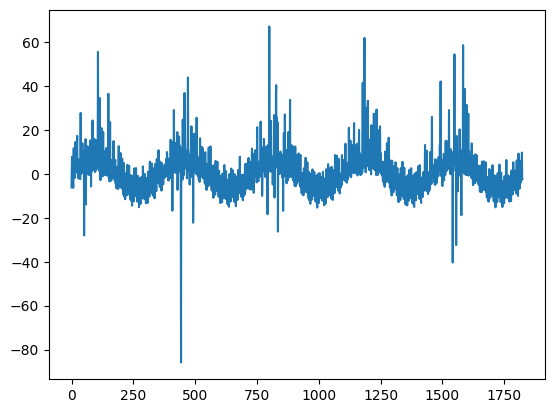

In [619]:
# Plot the full sequence for reference
plt.plot(y[0,:,0])

In [620]:
# RNN model
class RNNForecasting(nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(RNNForecasting, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        #self.relu = nn.ReLU(hidden_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size * 2)

    def forward(self, x, hidden):
        # Forward pass
        out, self.hidden = self.rnn(x, hidden)
        out = out[:, -1, :]
        y_h_std = self.fc(out)
        y_h = y_h_std[:, 0:1]
        std = torch.exp(y_h_std[:, 1:2])
        return y_h, std, hidden

    def init_hidden(self, batch_size):
        return torch.zeros(self.num_layers, batch_size, self.hidden_size)

# Gaussian log-likelihood loss function
def gaussian_log_likelihood(y, y_pred, log_std):
    std = torch.exp(log_std[0,0])
    log_likelihood = -0.5 * (torch.log(2 * torch.tensor(np.pi)) + 2 * log_std + ((y[0,0,0] - y_pred[0,0]) / std) ** 2)
    return -log_likelihood.mean()

def MSE(y, y_pred, log_std):
    return (y[0,0,0] - y_pred[0,0])**2


# Training function with fixed rolling window cross-validation
def train_fixed_rolling_window(model, optimizer, inputs, target, window_size, loss_fn):
    model.train()
    optimizer.zero_grad()
    num_windows = inputs.size(1) - window_size

    total_loss = 0
    for i in range(0,num_windows):
        if i % 10 == 0:
            input_window = inputs[:, i : (i + window_size), :]

            target_window = target[:, (i + window_size): (i + window_size + 1), :]

            # Initialize hidden state
            hidden = model.init_hidden(batch_size)

            # Forward pass
            y_h, std, _ = model(input_window, hidden)

            # Compute the loss for the current window
            loss = loss_fn(target_window, y_h, torch.log(std))#, model.y_h, smoothing=0.01)
            total_loss += loss

    # Average loss over all windows
    total_loss /= num_windows

    # Backward pass
    total_loss.backward()

    # Update the weights
    optimizer.step()

    return total_loss.item()



# Hyperparameters
input_size = 1
hidden_size = 20
output_size = 1
num_layers = 2
learning_rate = 0.001
epochs = 100

# Create the model
model = RNNForecasting(input_size, hidden_size, output_size, num_layers)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop with fixed rolling window cross-validation
window_size = 365
for epoch in range(epochs):
    loss = train_fixed_rolling_window(model, optimizer, inputs, target, window_size, gaussian_log_likelihood)

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss:.4f}')
        

AttributeError: 'RNNForecasting' object has no attribute 'save_last'

In [610]:
# Extract the crossvalidated fit
def extract_fit(model, inputs, target, window_size):
    num_windows = inputs.size(1) - window_size
    total_loss = 0
    y_pred = np.array([])
    y_sd = np.array([])
    targets = np.array([])
    for i in range(0,num_windows):
        input_window = inputs[:, i : (i + window_size), :]
        target_window = target[:, (i + window_size): (i + window_size + 1), :]

        targets = np.append(targets, target_window[0,0,0])

        # Forward pass
        y_h, std, _ = model(input_window, model.hidden)
        y_pred = np.append(y_pred, y_h.detach().numpy())
        y_sd = np.append(y_pred, std.detach().numpy())
    
    return y_pred, targets

y_pred, targets = extract_fit(model, inputs, target, window_size)





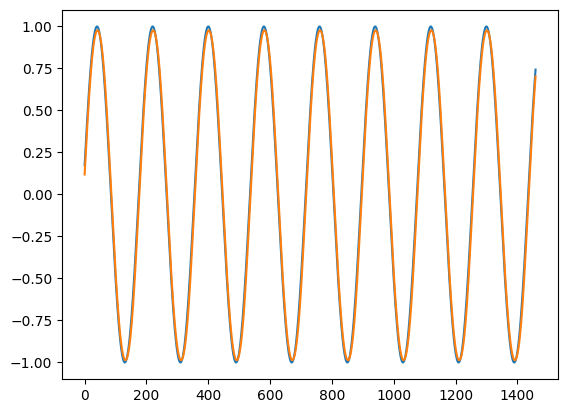

In [611]:

plt.plot(targets)
plt.plot(y_pred)
plt.show()